In [6]:
import numpy as np
import sys
import os

# Import Experiment class from FGPGM
fgpgm_root = "/home/dsemchin/Progression_models_simulations/FGPGM-master/FGPGM"
sys.path.append(fgpgm_root)
from Experiment import Experiment

import numpy as np
import matplotlib.pyplot as plt

class MultiBiomarkerLogistic(Experiment):
    def __init__(self, n_biomarkers=5):
        self.n_biomarkers = n_biomarkers
    
    def f(self, x, theta):
        """
        dx/dt = (I - diag(x)) @ (K @ x + f)
        """
        n = self.n_biomarkers
        f = theta[:n]  # First `n` elements are forcing terms

        # Reconstruct adjacency matrix K from theta
        K = np.zeros((n, n))
        upper_diag = theta[n:]  # Next `n-1` elements are the first off-diagonal
        for i in range(n - 1):
            K[i, i + 1] = upper_diag[i]
            K[i + 1, i] = upper_diag[i]  # Ensure symmetry

        # Compute dx/dt
        dx_dt = np.dot(np.eye(n) - np.diag(x), np.dot(K, x) + f)
        return dx_dt

    def getBounds(self, nStates, nParams, x0=None):
        """
        Returns bounds for states and parameters to constrain optimization.

        States (x) are between [0, 1].
        Forcing terms (f) can be small positive values.
        Connectivity (K elements) can be between [0, 2] since they're just 1s initially.

        Parameters:
        - nStates: Number of state variables
        - nParams: Number of parameters

        Returns:
        - xmin, xmax: Lists of lower and upper bounds
        """
        xmin = []
        xmax = []

        # Bounds for biomarker states
        for _ in range(nStates):
            xmin.append(0)
            xmax.append(2)

        # Bounds for forcing terms
        for _ in range(nStates):
            xmin.append(0)
            xmax.append(3)

        # Bounds for connectivity matrix off-diagonal elements
        for _ in range(nStates - 1):
            xmin.append(0)
            xmax.append(2) 

        return xmin, xmax


('time ', (10,))
('x_shape ', (5, 10))
('y_noisy', (5, 10))
('t_obs', (10,))
('x_obs', (5, 10))


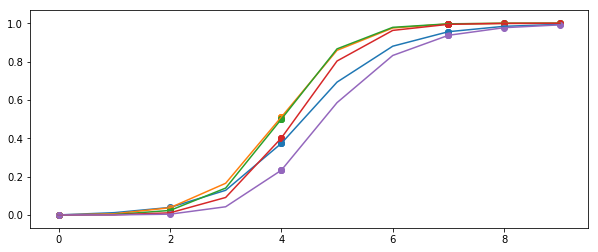

In [ ]:
np.random.seed(1)
n_biomarkers = 5
obsStd = 0.1  # noise

# initial conditions
XInit = np.zeros(n_biomarkers)
forcing_terms = np.zeros(n_biomarkers)
forcing_terms[0] = 0.01
connectivity_offdiag = np.ones(n_biomarkers - 1)
theta = np.concatenate([forcing_terms, connectivity_offdiag])

# time parameters
t_max = 10
dt = 1
time = np.arange(0, t_max, dt)

print("time ", time.shape)

experiment = MultiBiomarkerLogistic(n_biomarkers=n_biomarkers)

# simulate trajectory
x_true, y_noisy = experiment.sampleTrajectoryNonUniform(
    XInit,
    theta,
    time,
    obsNoiseStd=obsStd,
    SNR=None,
    plotting=None
)


if x_true.shape[0] != n_biomarkers:
    x_true = x_true.T
    
if y_noisy.shape[0] != n_biomarkers:
    y_noisy = y_noisy.T
    
print("x_shape ", x_true.shape)
print("y_noisy", y_noisy.shape)

# generate patietns
n_obs = 10
obs_indices = np.random.choice(len(time), size=n_obs, replace=False)
obs_indices.sort()
t_obs = time[obs_indices]
x_obs = x_true[:, obs_indices]

print("t_obs", t_obs.shape)
print("x_obs", x_obs.shape)

plt.figure(figsize=(10, 4))
for i in range(n_biomarkers):
    plt.plot(time, x_true[i])
    plt.scatter(t_obs, x_obs[i])
plt.show()

In [8]:
import sys
import os

sys.path.append('/home/dsemchin/Progression_models_simulations/FGPGM-master')
os.chdir('/home/dsemchin/Progression_models_simulations/FGPGM-master')

from FGPGM.Kernels.RBF import RBF
import numpy as np
import matplotlib.pyplot as plt

plt.switch_backend('agg')

standardize = True

"""kernel optimization """
# amount of basinhopping iterations in kernel hyperparameter optimization
kernelIter = 1  # should be adjusted based on roughness of likelihood
gammaValue = 3e-1

"""create Kernel and Kernel matrices"""
best_theta = []
best_sigma = []

for i in range(n_biomarkers):
    kernel = RBF(theta=np.abs(np.random.randn(2)),
                 sigma=np.abs(np.random.randn(1)))

    print("optimizing hyperparameters for biomarker", i + 1)

    kernel.learnHyperparams(
        kernel.theta,
        kernel.sigma,
        y_noisy[i, :],
        time,
        normalize=True,
        standardize=standardize,
        newNugget=1e-4,
        anneal=False,
        basinIter=kernelIter
    )

    print("optimal hyperparameters for biomarker", i + 1)
    print("gammaValue: ", gammaValue)
    print("theta: ", kernel.theta)
    print("sigma: ", kernel.sigma)

    best_theta.append(kernel.theta)
    best_sigma.append(kernel.sigma)

best_theta = np.array(best_theta)
best_sigma = np.array(best_sigma)


('optimizing hyperparameters for biomarker', 1)
using L-BFGS-B as hyperparameter optimizer
YES: 1.00009807954 @ [1.00000000e-04 6.05405325e+01 9.99996696e-01]
Kernel optimization output: 
                        fun: -0.23861297982603932
 lowest_optimization_result:       fun: -0.23861297982603932
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.1918912e-07, 8.8817842e-08, 3.1918912e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 14
   status: 0
  success: True
        x: array([0.93624032, 3.15160431, 0.31300623])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 116
                        nit: 1
                          x: array([0.93624032, 3.15160431, 0.31300623])


minimum eigenvalue = 0.000100006076004
('optimal hyperparameters for biomarker', 1)
('gammaValue: ', 0.3)
('theta: ', array([0.93624032, 

In [9]:
print(time.shape)
print("best_theta shape:", np.shape(best_theta))
print("best_sigma shape:", np.shape(best_sigma))

(10,)
('best_theta shape:', (5, 2))
('best_sigma shape:', (5,))


Use standardization of the observations
initialize with GP posterior
FGPGM blocked 0 potentially negative states
25 states needed correction, as they were too close to zero

state acceptance mean with std: 
0.32516 +- 0.13222956137

state acceptance range: 
0.17875 to 0.6875

param acceptance mean with std: 
0.781722222222 +- 0.0110192032156

param acceptance range: 
0.7655 to 0.808
[0.1374862  0.14483409 0.1884519  0.17971409 0.15045835 0.15246585
 0.15758738 0.15251467 0.20231841]


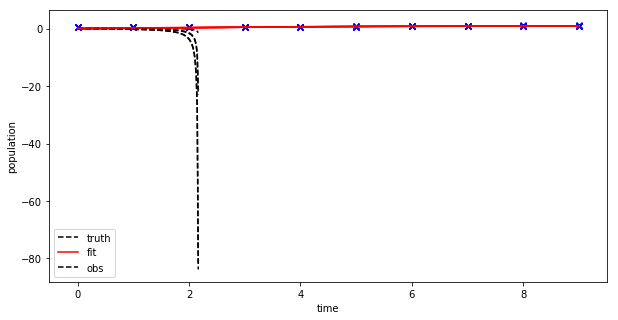

In [11]:
# -*- coding: utf-8 -*-
# Author: Philippe Wenk <philippewenk@hotmail.com>
"""
After experiments have been created using the script createExperiments.py,
this script can be run to infer the ODE parameters using FGPGM.
"""
import numpy as np

from FGPGM.Kernels.RBF import RBF as kernel
from FGPGM.FGPGM import FGPGM

from matplotlib import pyplot as plt
plt.switch_backend('agg')

"""determine standardization"""
if standardize == 0:
    standardize=False
    print("Do not use standardization of the observations")
elif standardize == 1:
    standardize=True
    print("Use standardization of the observations")
else:
    raise ValueError("Illegal value encountered in standardize.csv." +
                     "Maybe the file is corrupted?")

"""experiment and observation loading"""

# create experiment
experiment = MultiBiomarkerLogistic(n_biomarkers=n_biomarkers)
gammas = gammaValue*np.ones(y_noisy.T.shape[1])

"""create kernels using hyperparameters calculated by getHyperparams.py"""
kernels = []
for i in range(n_biomarkers):
    currentKernel = RBF(theta=best_theta[i], sigma=best_sigma[i])
    kernels.append(currentKernel)

"""find initial values for theta"""
trueTheta = theta
theta0 = np.abs(np.random.randn(trueTheta.size))    

y_forFGPGM = y_noisy.T

"""create FGPGM object"""
FM = FGPGM(kernels=kernels,
           time=time,
           y=y_noisy.T,
           experiment=experiment,
           nODEParams=trueTheta.size,
           gamma=gammas,
           normalize=True,
           standardize=standardize)

"""perform actual parameter estimation minimization"""
stateStds = np.ones(y_noisy.size)*0.075
paramStds = np.ones(theta0.size)*0.09
propStds = np.concatenate([stateStds, paramStds])

# print("As:", len(FM.As))
# print("Ds:", len(FM.Ds))
# print("Lambdas:", len(FM.Lambdas))
# print("y.shape:", y_noisy.shape)

newStates, newParams = FM.getFGPGMResults(GPPosteriorInit=True,
                                          blockNegStates=True,
                                          debug=True,
                                          theta0=theta0,
                                          thetaMagnitudes=np.zeros_like(theta0),
                                          nSamples=3000,
                                          nBurnin=1000,
                                          propStds=propStds)

print(newParams)

# np.savetxt("optimalParamsFGPGM.csv", newParams)
# np.savetxt("optimalStatesFGPGM.csv", newStates)
# print(newParams)

"""Visualizing the results"""
tEnd = time[-1]
timeDense = np.linspace(0, tEnd, 500)
XInit = y_noisy.T[0, :]  # Use first observed values as initial conditions

xDenseTrue = experiment.sampleTrajectoryNonUniform(XInit, trueTheta, timeDense, obsStd)[0]
xDenseNew = experiment.sampleTrajectoryNonUniform(XInit, newParams, timeDense, obsStd)[0]

plt.figure(figsize=(10, 5))
for i in range(xDenseNew.shape[1]):
    plt.plot(timeDense, xDenseTrue[:, i], 'k', linestyle="dashed")
    plt.plot(timeDense, xDenseNew[:, i], 'r')
    plt.scatter(time, newStates[:, i], marker='x', c='b')
    plt.xlabel("time")
    plt.ylabel("population")
    plt.legend(["truth", "fit", "obs"])
    plt.show()
